In [72]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [73]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd

import env

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (13, 5)

# Anomalies in time series

We will use a concept known as Bollinger Bands to discover when behavior changes from what is "expected" or normal. Bollinger Bands is a volatility indicator and commonly used in stock market trading.

Scenario: Discover anomalies in number of web pages accessed in a day by a user. Is there a bot copying the curriculum? 

In [19]:
dbname = "curriculum_logs"
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/{dbname}'

#what are the tables?
pd.read_sql("SHOW TABLES", url)

,Tables_in_curriculum_logs
0,cohorts
1,logs


In [15]:
df = pd.read_sql("SELECT * FROM logs", url)
df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [22]:
#prepare
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)
pages = df['path'].resample('d').count()

In [24]:
#EMA
ema_7d = pages.ewm(span=7).mean()
ema_14d = pages.ewm(span=14).mean()
ema_30d = pages.ewm(span=30).mean()
ema_90d = pages.ewm(span=90).mean()

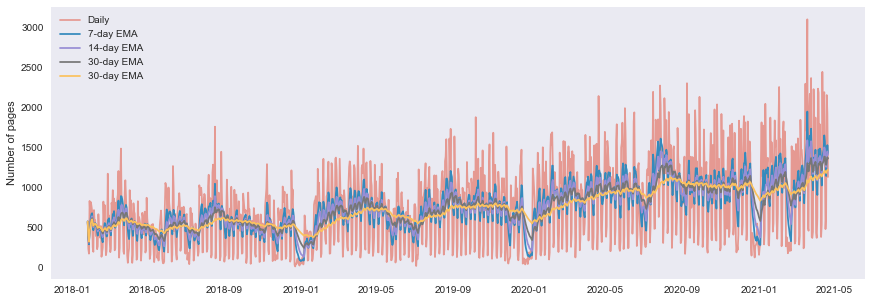

In [74]:
fig, ax = plt.subplots()

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [47]:
#Bollinger bands

# set the window span
span = 30
weight = 2

# compute midband
midband = pages.ewm(span=span).mean()
# compute exponential stdev
stdev = pages.ewm(span=span).std()
# compute upper and lower bands
ub = midband + stdev*weight
lb = midband - stdev*weight

# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)
bb.columns = ['ub', 'lb']
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']

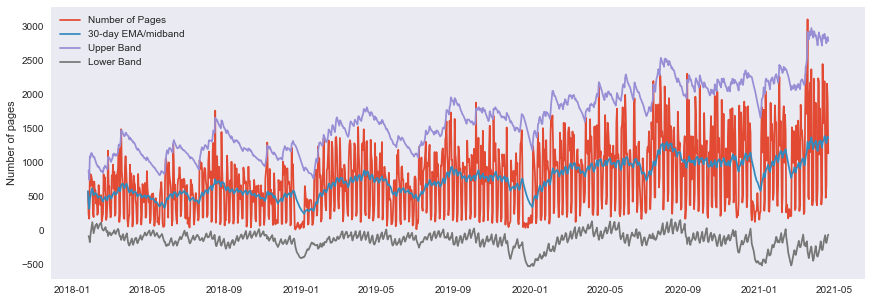

In [75]:
fig, ax = plt.subplots()

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [49]:
#Compute %b

# get the last measure of gb
last_measure = my_df.iloc[-1].pages
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lb
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

In [50]:
print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.42


In [51]:
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

In [58]:
thresh = 1.
#adjust span, weight, and thresh to change anomaly results
my_df[my_df.pct_b>thresh]

,pages,midband,ub,lb,pct_b
date,,,,,
2018-02-27,1171,496.375166,1077.905985,-85.155652,1.080042
2018-03-20,1486,665.021495,1472.918024,-142.875035,1.008096
2018-05-30,1056,400.137163,1018.214066,-217.939741,1.030567
2018-07-23,1027,435.495343,1010.366096,-139.375411,1.014468
2018-08-17,1760,751.910516,1655.512283,-151.691251,1.057817
2018-11-08,1291,561.449002,1248.899313,-126.001309,1.030621
2019-01-28,1232,447.643274,1168.205223,-272.918675,1.044267
2019-07-08,1225,479.213223,1215.420161,-256.993715,1.006506
2019-10-07,1879,803.738383,1792.312562,-184.835797,1.043845
